### Analisis Regresi Data Panel terhadap Faktor Penentu Pertumbuhan Inklusif di Berbagai Provinsi di Indonesia Selama 7 Tahun

#### Import Library

In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats 
from scipy.stats import f
from scipy.stats import chi2
from linearmodels.panel import compare
from linearmodels.panel import PanelOLS, RandomEffects
from statsmodels.api import OLS, add_constant
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

#### Load Data and Set Dataset Index 

In [2]:
dataset = pd.read_excel("Inclusive Growth Determinants.xlsx")
dataset = dataset.set_index(['Province', 'Year'])
dataset

GRDP Capita  GRDP Employed  Health Complaint  Formal Sector  \
Province Year                                                                
ACEH     2015     22524.31      53.990600             27.92         0.3950   
         2016     22835.29      56.680773             25.78         0.4283   
         2017     23362.90      56.179526             24.85         0.4042   
         2018     24013.79      56.608468             30.18         0.4056   
         2019     24842.30      55.897635             29.33         0.4288   
...                    ...            ...               ...            ...   
PAPUA    2017     45577.05      88.351497             16.53         0.2181   
         2018     48069.41      87.764036             17.60         0.2189   
         2019     40203.42      76.102458             15.20         0.2071   
         2020     32108.51      77.630270             16.27         0.2008   
         2021     36416.72      89.957372             12.74         0.1953   

               Unemployed Percent    HDI  Gov Spending  Gov CapEx  Poverty  \
Province Year                                                                
ACEH     2015               8.830  69.45      37549.69    8553.03   17.095   
         2016               7.850  70.00      42180.53    9870.07   16.580   
         2017               6.980  70.60      43580.96    8920.15   16.405   
         2018               6.440  71.19      38767.10    6320.93   15.825   
         2019               5.825  71.90      45620.69    8743.71   15.165   
...                           ...    ...           ...        ...      ...   
PAPUA    2017               3.790  59.09      49176.39    9608.32   27.690   
         2018               2.875  60.06      51086.73   10129.62   27.585   
         2019               3.365  60.84      51993.33    9839.85   27.040   
         2020               3.850  60.44      47564.27    6401.15   26.720   
         2021               3.550  60.62      50333.46    7063.85   27.120   

                 Gini  Decent Sanitation  Clean Water  HS Graduation  \
Province Year                                                          
ACEH     2015  0.3365              54.68        61.23          68.16   
         2016  0.3370              62.68        63.31          74.46   
         2017  0.3290              63.38        64.85          70.64   
         2018  0.3215              67.09        66.48          70.68   
         2019  0.3205              73.16        85.81          69.96   
...               ...                ...          ...            ...   
PAPUA    2017  0.3975              33.06        59.09          33.82   
         2018  0.3910              33.75        58.35          29.56   
         2019  0.3905              38.27        60.85          27.44   
         2020  0.3935              40.31        62.73          30.92   
         2021  0.3965              40.81        64.92          32.95   

                Agriculture  Life Expectancy  GRDP Nominal  \
Province Year                                                
ACEH     2015  37598.849177           69.540  1.290927e+08   
         2016  40218.310849           69.565  1.368438e+08   
         2017  43363.354290           69.585  1.458069e+08   
         2018  46365.383165           69.700  1.559110e+08   
         2019  48438.862870           69.915  1.641630e+08   
...                     ...              ...           ...   
PAPUA    2017  22274.746393           65.225  1.889381e+08   
         2018  23754.007686           65.445  2.106006e+08   
         2019  24177.230293           65.690  1.895107e+08   
         2020  24457.093241           65.835  1.992329e+08   
         2021  25516.439538           65.970  2.353432e+08   

               Population Thousand  
Province Year                       
ACEH     2015               5018.7  
         2016               5096.2  
         2017               5189.5  
         2018               5281.3  
         2019      

#### Variabel Dependen dan Independen

In [3]:
# Variabel dependen
y = dataset['Population Thousand']

# Menambahkan variabel-variabel ke X
X = dataset[['GRDP Capita', 'GRDP Employed', 'Health Complaint', 'Formal Sector', 
             'Unemployed Percent', 'HDI', 'Gov Spending', 'Gov CapEx', 
             'Poverty', 'Gini', 'Decent Sanitation', 'Clean Water', 
             'HS Graduation', 'Agriculture', 'Life Expectancy', 'GRDP Nominal']]

# Menambahkan konstanta intercept ke model
X = sm.add_constant(X)

#### Uji Chow

In [4]:
def chow_test(df, y_col, x_cols):
    df_period1 = df[df.index.get_level_values('Year') > 2018]
    df_period2 = df[df.index.get_level_values('Year') < 2021]

    X1, y1 = df_period1[x_cols], df_period1[y_col]
    X2, y2 = df_period2[x_cols], df_period2[y_col]

    X_combined = pd.concat([X1, X2])
    y_combined = pd.concat([y1, y2])

    model_combined = sm.OLS(y_combined, sm.add_constant(X_combined)).fit()
    model_1 = sm.OLS(y1, sm.add_constant(X1)).fit()
    model_2 = sm.OLS(y2, sm.add_constant(X2)).fit()

    RSS_combined = model_combined.ssr
    RSS_1 = model_1.ssr
    RSS_2 = model_2.ssr

    n1, n2 = len(y1), len(y2)
    k = X1.shape[1] + 1  

    # Menghitung F-statistic
    F_stat = ((RSS_combined - (RSS_1 + RSS_2)) / k) / ((RSS_1 + RSS_2) / (n1 + n2 - 2 * k))

    # Menghitung p-value
    df1 = k  
    df2 = (n1 + n2 - 2 * k) 
    p_value = 1 - f.cdf(F_stat, df1, df2)

    return F_stat, p_value, df1, df2

# Fungsi uji Chow
F_stat, p_value, df1, df2 = chow_test(
    dataset, 
    y_col='Population Thousand', 
    x_cols=['GRDP Capita', 'GRDP Employed', 'Health Complaint', 'Formal Sector', 
             'Unemployed Percent', 'HDI', 'Gov Spending', 'Gov CapEx', 
             'Poverty', 'Gini', 'Decent Sanitation', 'Clean Water', 
             'HS Graduation', 'Agriculture', 'Life Expectancy', 'GRDP Nominal']
)

print("--- Uji Chow ---\n")

# Hasil uji Chow
alpha = 0.05
print(f"F-Statistic: {F_stat}")
print(f"P-Value: {p_value}")

if p_value <= alpha:
    print("Terdapat dua model yang memiliki perbedaan signifikan.") 
    print("Hipotesis nol (H0) ditolak, langkah selanjutnya lakukan Uji Hausman.")
else:
    print("Tidak terdapat perbedaan signifikan antara dua model.") 
    print("Hipotesis nol (H0) gagal ditolak, langkah selanjutnya lakukan Uji Breusch-Pagan Lagrange Multiplier (LM).")

--- Uji Chow ---

F-Statistic: 1.5286844608881514
P-Value: 0.0841602102805018
Tidak terdapat perbedaan signifikan antara dua model.
Hipotesis nol (H0) gagal ditolak, langkah selanjutnya lakukan Uji Breusch-Pagan Lagrange Multiplier (LM).


#### Uji Breusch-Pagan Lagrange Multiplier (LM)

In [5]:
def breusch_pagan_test(df, y_col, x_cols):
    X = df[x_cols]
    y = df[y_col]
    X = sm.add_constant(X)
    
    model = sm.OLS(y, X).fit()
    
    # Uji Breusch-Pagan
    lm_test = het_breuschpagan(model.resid, X)
    lm_stat = lm_test[0]
    lm_pvalue = lm_test[1]
    
    return lm_stat, lm_pvalue

lm_stat, lm_pvalue = breusch_pagan_test(
    dataset,
    y_col='Population Thousand',
    x_cols=['GRDP Capita', 'GRDP Employed', 'Health Complaint', 'Formal Sector', 
             'Unemployed Percent', 'HDI', 'Gov Spending', 'Gov CapEx', 
             'Poverty', 'Gini', 'Decent Sanitation', 'Clean Water', 
             'HS Graduation', 'Agriculture', 'Life Expectancy', 'GRDP Nominal'])

# Menampilkan hasil
alpha = 0.05
print("--- Uji Breusch-Pagan Lagrange Multiplier (LM) ---\n")
print(f"LM Statistic: {lm_stat}")
print(f"P-Value: {lm_pvalue}")

if lm_pvalue <= alpha:
    print("Hipotesis nol (H0) ditolak. Langkah selanjutnya lakukan Uji Hausman.")
else:
    print("Hipotesis nol (H0) gagal ditolak. Model Pooled OLS/Common Effect Model lebih sesuai dan dapat digunakan.")

--- Uji Breusch-Pagan Lagrange Multiplier (LM) ---

LM Statistic: 52.85590436806245
P-Value: 7.962668873629385e-06
Hipotesis nol (H0) ditolak. Langkah selanjutnya lakukan Uji Hausman.


#### Uji Hausman

In [6]:
def hausman_test(df, y_col, x_cols):
    X = sm.add_constant(df[x_cols])
    y = df[y_col]
    
    # Model Fixed Effect
    fixed_effects_model = PanelOLS(y, X, entity_effects=True)
    fixed_results = fixed_effects_model.fit()
    fixed_coefficients = fixed_results.params
    fixed_cov_matrix = fixed_results.cov
    
    # Model Random Effect
    random_effects_model = RandomEffects(y, X)
    random_results = random_effects_model.fit()
    random_coefficients = random_results.params
    random_cov_matrix = random_results.cov
    
    diff_coeff = fixed_coefficients - random_coefficients
    diff_cov = fixed_cov_matrix - random_cov_matrix
    hausman_stat = diff_coeff.T @ np.linalg.inv(diff_cov) @ diff_coeff
    
    df = len(diff_coeff)
    p_value = 1 - chi2.cdf(hausman_stat, df)
    return hausman_stat, p_value

hausman_stat, p_value = hausman_test(
    dataset,
    y_col='Population Thousand',
    x_cols=['GRDP Capita', 'GRDP Employed', 'Health Complaint', 'Formal Sector', 
             'Unemployed Percent', 'HDI', 'Gov Spending', 'Gov CapEx', 
             'Poverty', 'Gini', 'Decent Sanitation', 'Clean Water', 
             'HS Graduation', 'Agriculture', 'Life Expectancy', 'GRDP Nominal']
)

# Menampilkan hasil
alpha = 0.05
print("--- Uji Hausman ---\n")
print(f"Hausman Statistic: {hausman_stat}")
print(f"P-Value: {p_value}")

if p_value <= alpha:
    print("Hipotesis nol (H0) ditolak. Model Fixed Effect lebih sesuai.")
else:
    print("Hipotesis nol (H0) gagal ditolak. Model Random Effect lebih sesuai.")

--- Uji Hausman ---

Hausman Statistic: -63.824792637637636
P-Value: 1.0
Hipotesis nol (H0) gagal ditolak. Model Random Effect lebih sesuai.


#### Random Effect Model

In [7]:
# Model Random Effects
random_effects_model = RandomEffects(y, X)
random_results = random_effects_model.fit()

# Hasil 
print("\nHasil Random Effect Model:")
print(random_results)


Hasil Random Effect Model:
                         RandomEffects Estimation Summary                        
Dep. Variable:     Population Thousand   R-squared:                        0.5010
Estimator:               RandomEffects   R-squared (Between):              0.4834
No. Observations:                  238   R-squared (Within):               0.5277
Date:                 Thu, Nov 28 2024   R-squared (Overall):              0.4834
Time:                         22:28:58   Log-likelihood                   -1734.5
Cov. Estimator:             Unadjusted                                           
                                         F-statistic:                      13.870
Entities:                           34   P-value                           0.0000
Avg Obs:                        7.0000   Distribution:                  F(16,221)
Min Obs:                        7.0000                                           
Max Obs:                        7.0000   F-statistic (robust):        

#### Uji Heteroskedastisitas

In [8]:
# Residual dari model Random Effects
residuals = random_results.resids

# Uji Breusch-Pagan untuk heteroskedastisitas
bp_test = het_breuschpagan(residuals, X)

# Menampilkan hasil uji
print("--- Uji Heteroskedastisitas ---\n")
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
results = dict(zip(labels, bp_test))
for key, value in results.items():
    print(f"{key}: {value}")

# Menentukan hasil uji heteroskedastisitas
significance_level = 0.05 
p_value = bp_test[1]
if p_value <= significance_level:
    print("\nTerdapat Heteroskedastisitas.")
else:
    print("\nTidak terdapat Heteroskedastisitas.")

--- Uji Heteroskedastisitas ---

Lagrange multiplier statistic: 104.43725559285835
p-value: 5.072004023946914e-15
f-value: 10.800463851499167
f p-value: 3.288773067841732e-20

Terdapat Heteroskedastisitas.


#### Transformasi Data

In [9]:
dataset_transformed = dataset.copy()

# Transformasi log pada variabel target
dataset_transformed['Population Thousand'] = np.log(dataset['Population Thousand'])

# Variabel yang akan ditransformasi log
log_columns = ['GRDP Capita', 'GRDP Employed', 'Health Complaint', 'Formal Sector', 
               'Unemployed Percent', 'HDI', 'Gov Spending', 'Gov CapEx', 
               'Poverty', 'Gini', 'Decent Sanitation', 'Clean Water', 
               'HS Graduation', 'Agriculture', 'Life Expectancy', 'GRDP Nominal']

# Transformasi log pada variabel-variabel independen
dataset_transformed[log_columns] = np.log(dataset[log_columns] + 1)

# Variabel dependen dan independen setelah transformasi
y_transformed = dataset_transformed['Population Thousand']
X_transformed = dataset_transformed[log_columns]
X_transformed = sm.add_constant(X_transformed)

# Menampilkan dataset hasil transformasi
dataset_transformed

GRDP Capita  GRDP Employed  Health Complaint  Formal Sector  \
Province Year                                                                
ACEH     2015    10.022395       4.007162          3.364533       0.332894   
         2016    10.036106       4.054924          3.287655       0.356485   
         2017    10.058947       4.046196          3.252311       0.339468   
         2018    10.086425       4.053670          3.439777       0.340464   
         2019    10.120343       4.041254          3.412137       0.356835   
...                    ...            ...               ...            ...   
PAPUA    2017    10.727182       4.492578          2.863914       0.197292   
         2018    10.780422       4.485982          2.923162       0.197949   
         2019    10.601732       4.345135          2.785011       0.188221   
         2020    10.376908       4.364757          2.848971       0.182988   
         2021    10.502811       4.510391          2.620311       0.178397   

               Unemployed Percent       HDI  Gov Spending  Gov CapEx  \
Province Year                                                          
ACEH     2015            2.285439  4.254903     10.533447   9.054158   
         2016            2.180417  4.262680     10.649738   9.197364   
         2017            2.076938  4.271095     10.682399   9.096180   
         2018            2.006871  4.279302     10.565353   8.751780   
         2019            1.920592  4.289089     10.728139   9.076204   
...                           ...       ...           ...        ...   
PAPUA    2017            1.566530  4.095843     10.803189   9.170489   
         2018            1.354546  4.111857     10.841300   9.223318   
         2019            1.473618  4.124550     10.858890   9.194297   
         2020            1.578979  4.118061     10.769858   8.764389   
         2021            1.515127  4.120986     10.826445   8.862887   

                Poverty      Gini  Decent Sanitation  Clean Water  \
Province Year                                                       
ACEH     2015  2.895636  0.290054           4.019621     4.130837   
         2016  2.866762  0.290428           4.153871     4.163715   
         2017  2.856758  0.284427           4.164803     4.187379   
         2018  2.822866  0.278767           4.220830     4.211831   
         2019  2.782848  0.278010           4.306225     4.463722   
...                 ...       ...                ...          ...   
PAPUA    2017  3.356549  0.334685           3.528124     4.095843   
         2018  3.352882  0.330023           3.548180     4.083452   
         2019  3.333632  0.329663           3.670461     4.124712   
         2020  3.322154  0.331819           3.721105     4.154655   
         2021  3.336481  0.333969           3.733136     4.188442   

               HS Graduation  Agriculture  Life Expectancy  GRDP Nominal  \
Province Year                                                              
ACEH     2015       4.236423    10.534755         4.256180     18.676041   
         2016       4.323603    10.602103         4.256534     18.734351   
         2017       4.271654    10.677393         4.256818     18.797794   
         2018       4.272212    10.744330         4.258446     18.864796   
         2019       4.262116    10.788078         4.261482     18.916370   
...                      ...          ...              ...           ...   
PAPUA    2017       3.550192    10.011254         4.193058     19.056930   
         2018       3.419692    10.075549         4.196375     19.165474   
         2019       3.347797    10.093208         4.200055     19.059956   
         2020       3.463233    10.104716         4.202227     19.109985   
         2021       3.524889    10.147117         4.204245     19.276556   

               Population Thousand  
Province Year                       
ACEH     2015             8.520926  
         2016             8.536250  
         2017             8.

#### Uji Heteroskedastisitas setelah transformasi

In [10]:
model_log = sm.OLS(y_transformed, X_transformed).fit()
bp_test_log = het_breuschpagan(model_log.resid, X_transformed)

# Menampilkan hasil uji
print("--- Uji Heteroskedastisitas Setelah Transform Data ---\n")
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
results = dict(zip(labels, bp_test_log))
for key, value in results.items():
    print(f"{key}: {value}")

# Menentukan heteroskedastisitas atau tidak
alpha = 0.05
p_value = bp_test_log[1]
if p_value <= alpha:
    print("\nTerdapat Heteroskedastisitas.")
else:
    print("\nTidak terdapat Heteroskedastisitas.")

--- Uji Heteroskedastisitas Setelah Transform Data ---

Lagrange multiplier statistic: 22.78211600257567
p-value: 0.11968436502791945
f-value: 1.462136749236613
f p-value: 0.1155979864897042

Tidak terdapat Heteroskedastisitas.


#### Evaluasi model

In [11]:
significance_level = 0.05

# Variabel yang signifikan
significant_vars = random_results.pvalues[random_results.pvalues < significance_level]
significant_df = pd.DataFrame({
    'Variable': significant_vars.index,
    'P-Value': significant_vars.values
}).sort_values(by='P-Value')

# Variabel yang tidak signifikan
insignificant_vars = random_results.pvalues[random_results.pvalues >= significance_level]
insignificant_df = pd.DataFrame({
    'Variable': insignificant_vars.index,
    'P-Value': insignificant_vars.values
}).sort_values(by='P-Value')

print("--- Variabel Signifikan pada Tingkat Signifikansi 5% ---")
print(significant_df.to_string(index=False))

print("\n--- Variabel Tidak Signifikan pada Tingkat Signifikansi 5% ---")
print(insignificant_df.to_string(index=False))

--- Variabel Signifikan pada Tingkat Signifikansi 5% ---
       Variable  P-Value
    GRDP Capita 0.000021
   GRDP Nominal 0.002230
    Agriculture 0.002407
Life Expectancy 0.009975
   Gov Spending 0.029548
          const 0.032655

--- Variabel Tidak Signifikan pada Tingkat Signifikansi 5% ---
          Variable  P-Value
       Clean Water 0.150549
     Formal Sector 0.183918
              Gini 0.191670
Unemployed Percent 0.239435
     HS Graduation 0.438681
 Decent Sanitation 0.493728
               HDI 0.620213
     GRDP Employed 0.648726
  Health Complaint 0.748424
         Gov CapEx 0.864096
           Poverty 0.879638


#### Visyualisasi Evaluasi Model

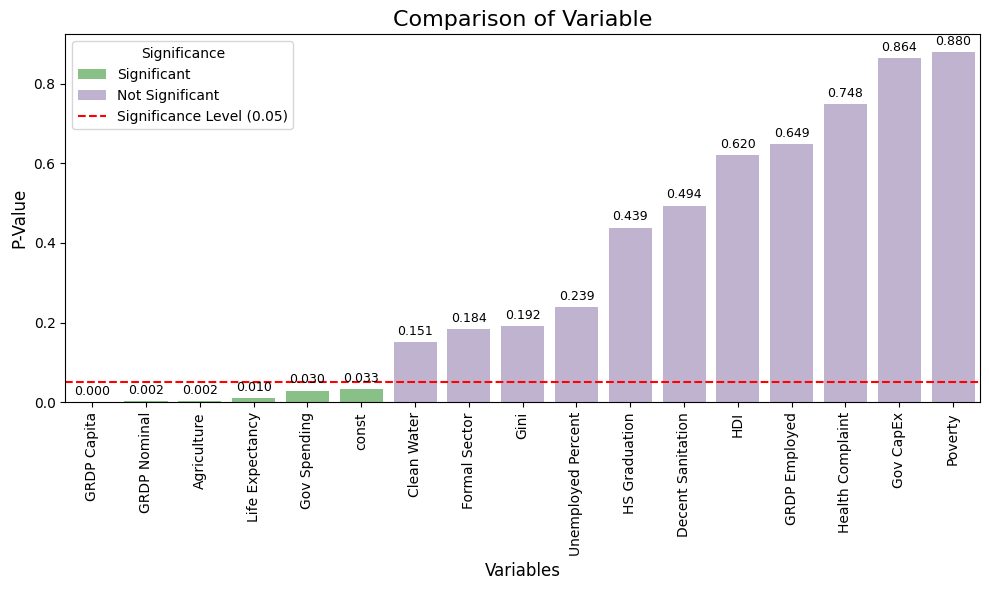

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

significant_df['Significance'] = 'Significant'
insignificant_df['Significance'] = 'Not Significant'

comparison_df = pd.concat([significant_df, insignificant_df], axis=0)

# Plotting
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=comparison_df,
    x='Variable',
    y='P-Value',
    hue='Significance',
    palette='Accent')

plt.axhline(y=significance_level, color='red', linestyle='--', label='Significance Level (0.05)')

for container in ax.containers:
    ax.bar_label(
        container,
        fmt='%.3f',  
        padding=3,   
        fontsize=9,  
        color='black')

plt.title('Comparison of Variable', fontsize=16)
plt.xlabel('Variables', fontsize=12)
plt.ylabel('P-Value', fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.legend(title='Significance', fontsize=10)
plt.tight_layout()
plt.show()